# Evaluating a Pre-trained Model for Semantic Search (Retrieval)
**Author:** Wei Wang

- **Dataset:** ESCI Shopping Queries Data Set (Reduced Version / Full Version) ([GitHub link](https://github.com/amazon-science/esci-data))
- **Model:** all-MiniLM-L6-v2 ([Hugging Face link](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2))
- **Task:** Evaluate model performance directly on the dataset without fine-tuning.
- **Metric:** NDCG@10, recall@10 and MRR@10.

---

## Import libraries

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

# Local application/library specific imports
os.chdir('../') 
print("Current Working Directory:", os.getcwd())
from src.data_loader import DataLoader
from src.data_preprocessor import DataPreprocessor
from src.model_evaluator import ModelEvaluator

Current Working Directory: c:\Users\Wei\Assignment\Semantic-Search-Evaluation


c:\Users\Wei\Assignment\Semantic-Search-Evaluation\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Overview

### ESCI Data

The **Shopping Queries Data Set** ([GitHub link](https://github.com/amazon-science/esci-data)) is a large-scale, manually annotated collection of challenging search queries, designed to support research in semantic matching between queries and products.

For each query, the dataset includes up to 40 potentially relevant products, each annotated with an ESCI relevance judgment:

- **Exact match (E)**
- **Substitute (S)**
- **Complement (C)**
- **Irrelevant (I)**

These labels indicate how well each product aligns with the query. Each query-product pair is also accompanied by additional contextual information.  
The dataset is **multilingual**, featuring queries in **English (us)**, **Japanese (jp)**, and **Spanish (es)**.

---

#### Full Dataset

- **130,652** unique queries
- **2,621,738** query-item pairs
- Provides a broad and comprehensive set of examples for extensive training and evaluation

#### Reduced Version (Provided by the Authors)

- **48,300** unique queries
- **1,118,011** query-item pairs
- Focuses on more challenging queries, with "easy" queries filtered out

The dataset is stratified by queries into **train** and **test** splits initially.

---

### Data Fields

Each entry in the dataset contains the following fields:

`example_id`, `query`, `query_id`, `product_id`, `product_locale`, `esci_label`, `small_version`, `large_version`, `split`, `product_title`, `product_description`, `product_bullet_point`, `product_brand`, `product_color`, `source`

### Columns Used for This Task

For the purposes of this task, we focus on the following columns:

- `query`
- `product_title`
- `product_description`
- `product_locale`
- `small_version`
- `large_version`
- `split`
- `esci_label`

These fields provide the essential information needed for training and evaluating semantic search models, combining textual content from queries and products with structured relevance labels for supervised learning.

---

In [7]:
# Take a look at the ESCI dataset
loaded_data = DataLoader(
        example_path="../dataset/shopping_queries_dataset_examples.parquet",
        products_path="../dataset/shopping_queries_dataset_products.parquet",
        small_version=True, # Load a small version of the dataset for data exploration
    )
loaded_data.load_data()
loaded_data.df.head(5)

,query,title,description,relevance,split,product_locale
16,!awnmower tires without rims,"RamPro 10"" All Purpose Utility Air Tires/Wheel...","<b>About The Ram-Pro All Purpose Utility 10"" A...",1,train,us
17,!awnmower tires without rims,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,4,train,us
18,!awnmower tires without rims,NEIKO 20601A 14.5 inch Steel Tire Spoon Lever ...,None,1,train,us
19,!awnmower tires without rims,2PK 13x5.00-6 13x5.00x6 13x5x6 13x5-6 2PLY Tur...,"Tire Size: 13 x 5.00 - 6 Axle: 3/4"" inside dia...",3,train,us
20,!awnmower tires without rims,(Set of 2) 15x6.00-6 Husqvarna/Poulan Tire Whe...,No fuss. Just take off your old assembly and r...,4,train,us


### Data Preprocessing

In preparation for semantic search and product retrieval tasks, I performed a comprehensive data cleaning process on the **Shopping Queries Data Set**. This was necessary to ensure that the input text is clean, meaningful, and suitable for downstream modeling.

---

#### Key Data Cleaning Steps

##### 1. Removal of HTML Tags and Special Characters

Upon inspecting the extracted vocabulary, it became clear that a significant portion of the words were HTML tags rather than meaningful content. These tags introduce noise into both bag-of-words models and semantic search embeddings.

To address this, I systematically removed all HTML tags from the following text fields:
- **query**
- **product_title**
- **product_description**

For English-language (`us`) data, I further cleaned the text by removing special characters and symbols that do not contribute to the semantic meaning of the text. This included punctuation marks, brackets, and other non-alphanumeric characters, while preserving spaces to maintain word boundaries.

This ensured that only the true textual content was retained for model training and evaluation.

##### 2. Drop NULL Value
Drop rows where any of the following columns are NULL:
- **query**
- **product_title**

I have excluded **product_description** since in general cases, description is considered optional, while query and product_title are essential for search and matching.

##### 3. Conversion of ESCI Labels to Digits

To facilitate model training and evaluation, the categorical ESCI labels were mapped to numerical values.  
This conversion allows relevance judgments to be handled easily in classification tasks or scoring models.

The mapping is as follows:

- **E (Exact match)** → **4**
- **S (Substitute)** → **3**
- **C (Complement)** → **2**
- **I (Irrelevant)** → **1**

By converting the labels to integers, it becomes possible to apply standard machine learning algorithms that require numerical targets, and to compute ranking metrics (such as NDCG) in a straightforward way.


##### 4. Text Normalization

As part of the cleaning process:
- All text was converted to **lowercase** to ensure case-insensitive matching.
- Tokenization steps (for bag-of-words analysis) were performed on clean, normalized text.



##### 5. Locale Filtering

Since the dataset is multilingual (English, Japanese, Spanish), I filtered the data to focus only on the desired locale (e.g., English `"us"`) when necessary.  
Different languages may result different evluation results.



##### 6. Creation of Combined Text Field

Since the task is not asking for fine tuning, I created a new field, **`combined_text`**, by concatenating the cleaned `product_title` and `product_description`.  
This allowed the models to leverage richer product information and better capture the full semantic context during model evluation.




In [8]:
# Run preprocessing on the loaded data
data_preprocessor = DataPreprocessor(loaded_data.df,language="us")
data_preprocessor.get_bag_of_words()

,word,frequency
18,br,4056430
48,la,438325
66,para,414585
30,el,331113
53,li,321154
...,...,...
6,18,46060
13,baby,46022
95,waist,45831
81,skin,45089


In [9]:
# Clean the data
data_preprocessor.data_preprocessing()

In [10]:
# Take a look at the cleaned data stats
print("Data stats after preprocessing:")
data_preprocessor.get_dataset_stats()

Data stats after preprocessing:


{'total_samples': 1118011,
 'unique_queries': 48241,
 'avg_products_per_query': 23.175535333015485,
 'relevance_distribution': {1: 0.16764235772277733,
  2: 0.05150396552448947,
  3: 0.343023458624289,
  4: 0.4378302181284442},
 'locale_distribution': {'us': 0.5378784287453343,
  'jp': 0.26644013341550304,
  'es': 0.1956814378391626}}

In [12]:
# Cleaned data sample
print("Sample of cleaned data:")
data_preprocessor.df.head(5)

Sample of cleaned data:


,query,title,description,relevance,split,product_locale,combined_text
16,awnmower tires without rims,rampro 10 all purpose utility air tires wheel...,about the ram pro all purpose utility 10 air ...,1,train,us,rampro 10 all purpose utility air tires wheel...
17,awnmower tires without rims,maxauto 2 pack 13x5 00 6 2ply turf mower tract...,maxauto 2 pack 13x5 00 6 2ply turf mower tract...,4,train,us,maxauto 2 pack 13x5 00 6 2ply turf mower tract...
18,awnmower tires without rims,neiko 20601a 14 5 inch steel tire spoon lever ...,,1,train,us,neiko 20601a 14 5 inch steel tire spoon lever ...
19,awnmower tires without rims,2pk 13x5 00 6 13x5 00x6 13x5x6 13x5 6 2ply tur...,tire size 13 x 5 00 6 axle 3 4 inside dia...,3,train,us,2pk 13x5 00 6 13x5 00x6 13x5x6 13x5 6 2ply tur...
20,awnmower tires without rims,set of 2 15x6 00 6 husqvarna poulan tire whe...,no fuss just take off your old assembly and r...,4,train,us,set of 2 15x6 00 6 husqvarna poulan tire whe...


## Model Selection

### Model Selection: all-MiniLM-L6-v2

For this semantic search task, I selected the **all-MiniLM-L6-v2** model from the Sentence Transformers library.  

---

This decision was based on several key factors:

- **Lightweight and Efficient:**  
  all-MiniLM-L6-v2 maps sentences and paragraphs into a 384-dimensional dense vector space, making it highly efficient in terms of both computation and memory usage compared to larger models like BERT or RoBERTa.

- **Optimized for Semantic Search:**  
  The model has been specifically fine-tuned for semantic textual similarity tasks, making it a strong candidate for retrieval tasks where capturing the true meaning of queries and product descriptions is critical.

- **Performance vs. Speed Trade-off:**  
  It strikes a good balance between retrieval accuracy and inference speed, making it suitable for large-scale product search where latency can be a concern.
  
  From [SBERT.net](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html): The **all-mpnet-base-v2** model provides the best quality, while **all-MiniLM-L6-v2** is 5 times faster and still offers good quality.

- **Multilingual Capabilities:**  
  Although primarily trained on English, all-MiniLM-L6-v2 demonstrates reasonable generalization across multiple languages.  
  Given that the ESCI Data Set includes English, Japanese, and Spanish queries, selecting a model capable of handling multilingual input was essential for broad evaluation coverage.

- **Pre-trained Quality:**  
  Pre-trained on a large and diverse corpus of sentence pairs, all-MiniLM-L6-v2 offers robust out-of-the-box performance without the need for extensive additional fine-tuning.

- **Community Adoption and Benchmarks:**  
  It is widely adopted in industry and research for search, clustering, and question-answering tasks, with consistently strong performance in standard semantic similarity benchmarks.

Given these advantages, **all-MiniLM-L6-v2** was a practical and powerful choice.

The following table provides an overview of a selection of sentence transformer models.

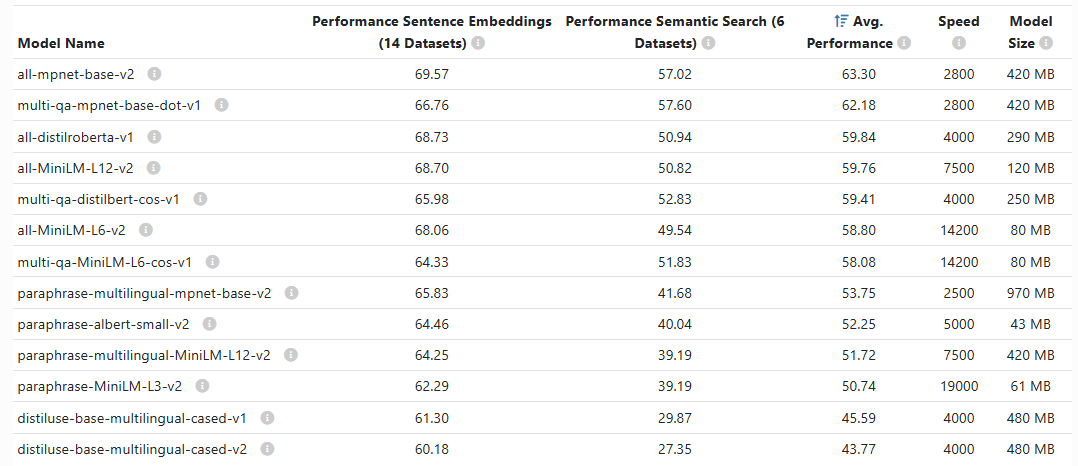

## Model Evaluation

### Model Evaluation Summary

**all-MiniLM-L6-v2** model was evaluated for semantic retrieval across different dataset sizes and language subsets of the ESCI data set (results are shown above the markdown). The results demonstrate strong performance across all settings.

For each query, the evaluation process involved computing cosine similarity between the query embedding and a selected set of product embeddings (typically 24, 100, or all available products depending on the experiment), ranking products by similarity, and calculating information retrieval metrics — NDCG@k, Recall@k, and MRR@k. These metrics collectively measure the ranking quality, retrieval accuracy, and how early the relevant items appear in the ranked list.

---

#### Key Observations

- **Reduced (Small) Dataset (All Languages):**
  - Achieved an average NDCG@10 of 0.90, average MRR@10 of 0.915 and average Recall@10 of 0.55.
  - Required significantly less time (~20 minutes).
  - Performance remained high despite using fewer queries and samples.

- **Reduced (Small) Dataset (English Locale "us" Only):**
  - Achieved the highest average NDCG@10 (**0.906**) and average MRR@10 (**0.924**) among the small dataset evaluations.
  - Recall@10 also improved (**0.603**), suggesting stronger top-10 retrieval accuracy when focusing only on English queries.
  - Processing time was faster than all language dataset (~12 minutes).

- **Small Dataset (JP Locale "jp" Only):**
  - Achieved the lowest NDCG@10 of **0.892** and the lowest MRR@10 of **0.902**.
  - Slightly lower recall (**0.449**) compared to US data, likely reflecting differences in language structure or dataset size.
  - Processing completed in about ~8 minutes.

- **Full Dataset (All Languages):**
  - Achieved a very high average NDCG@10 of 0.948, an average MRR@10 of 0.957 and an average Recall@10 0.59.
  - Total training and evaluation time was approximately **2909 seconds** (~48 minutes).
  - The model maintained strong retrieval quality even on the large-scale dataset (2.6M samples).

- **Full Dataset (English Locale "us" Only):**
  - Achieved the best overall performance with an average NDCG@10 of **0.956** and an average MRR@10** of **0.966**.
  - Recall@10 reached **0.614**, the highest across all settings.
  - Processing time was approximately 34 minutes.
  - Indicates that limiting to English ("us" locale) helps the model achieve even stronger semantic matching results.

- **Full Dataset (JP Locale "jp" Only):**
  - Achieved a lowest average NDCG@10 of **0.923** and a lowest average MRR@10 of **0.932**.
  - Recall was slightly lower (**0.498**) compared to the US dataset, but still strong.
  - Processing time was approximately **693 seconds** (~11.5 minutes).

- **Small Dataset (JP Locale "jp" Only, 100 Products per Query):**
  
  When each query was evaluated against a larger candidate set (100 products), performance dropped: 
  - NDCG@10 fell to 0.844
  - Recall@10 dropped to 0.259
  - MRR@10 dropped to 0.725

Indicates that retrieval becomes more difficult as the candidate set increases.

---

#### Summary

Overall, the **all-MiniLM-L6-v2** model demonstrated excellent performance for semantic retrieval tasks across both full and reduced datasets.  
Using a smaller dataset incurred minimal loss in effectiveness, while substantially improving evaluation speed.  
Filtering the data to English-only queries ("us" locale) further boosted NDCG, Recall, and MRR, confirming that the model handles English data slightly better than multilingual data.

Performance on Japanese ("jp" locale) queries was consistently lower. The drop in metrics when increasing the candidate pool from ~24 to 100 per query (as seen in "JP Small 100") highlights the challenge of semantic ranking under more realistic conditions.
This confirms that while the model performs well in small candidates pool size, larger-scale retrieval will likely drop the model performance. It requires more precise ranking, which may benefit from fine-tuning or reranking models.

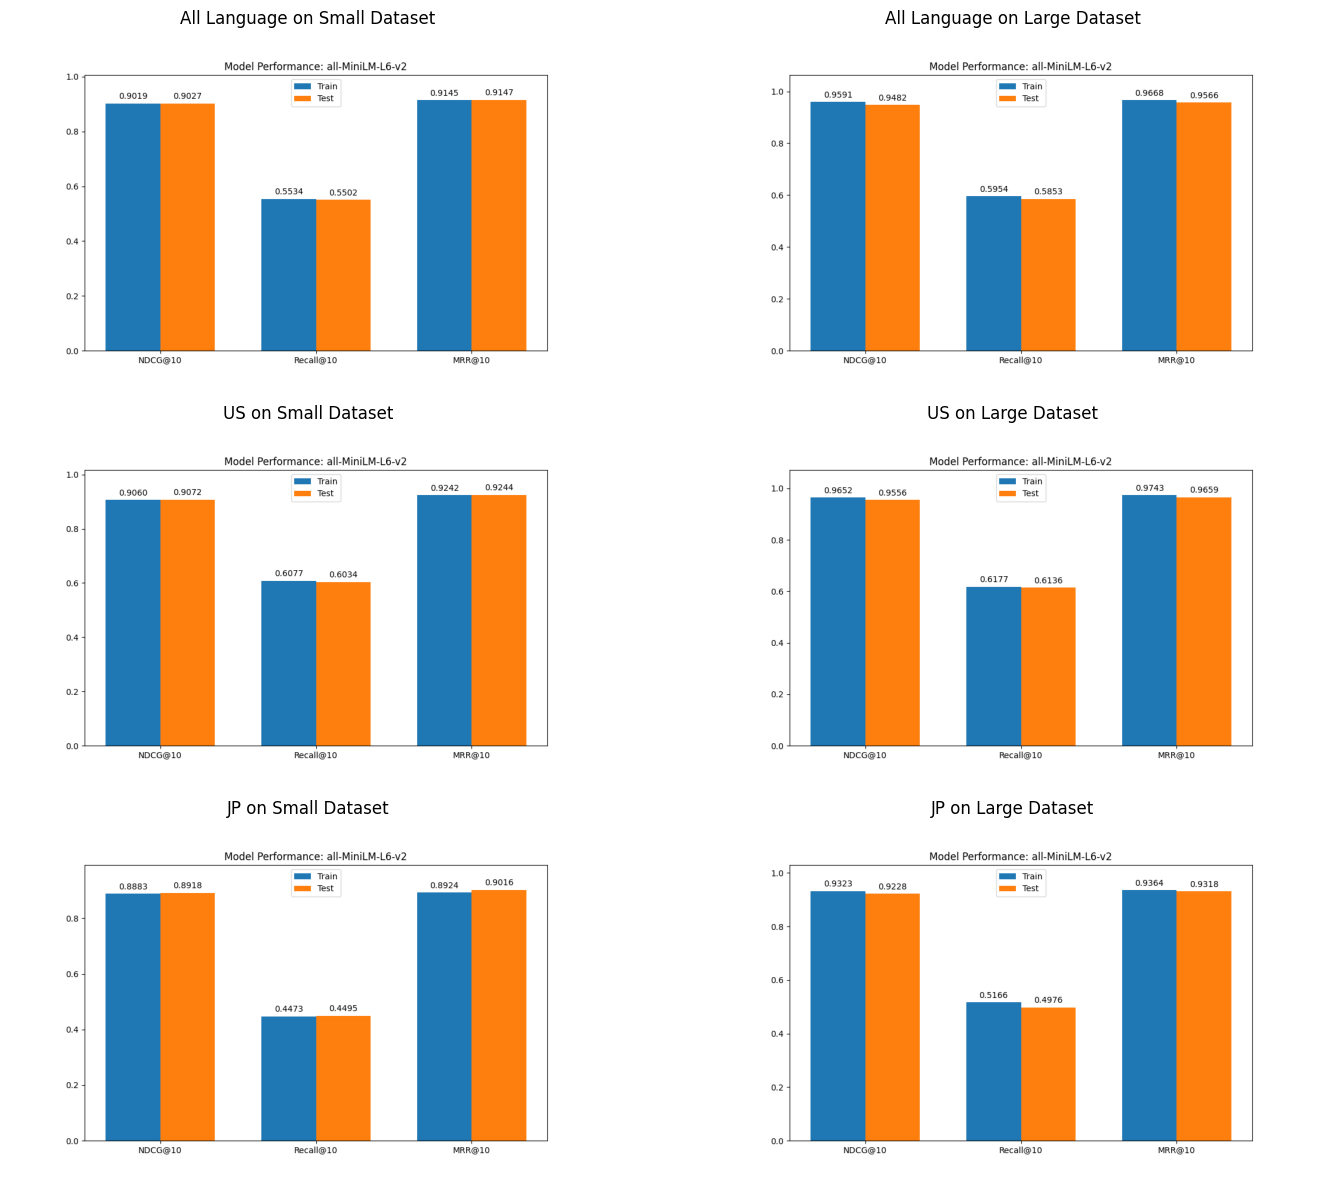

In [21]:
# List of image paths
image_paths = [
    "output/all-MiniLM-L6-v2_all_small_metrics.png",
    "output/all-MiniLM-L6-v2_all_large_metrics.png",
    "output/all-MiniLM-L6-v2_us_metrics.png",
    "output/all-MiniLM-L6-v2_us_large_metrics.png",
    "output/all-MiniLM-L6-v2_jp_small_metrics.png",
    "output/all-MiniLM-L6-v2_jp_large_metrics.png",
]
label_names = [
    "All Language on Small Dataset",
    "All Language on Large Dataset",
    "US on Small Dataset",
    "US on Large Dataset",
    "JP on Small Dataset",
    "JP on Large Dataset",
]
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3x2 grid
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Load and display each image
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path)
    axes[i].imshow(np.array(img))
    axes[i].set_title(f"{label_names[i]}")
    axes[i].axis('off')  # Turn off axis numbers

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [22]:
# load all the evluation results
all_small_result = pd.read_csv("output/all-MiniLM-L6-v2_all_small_results.csv")
us_large_result = pd.read_csv("output/all-MiniLM-L6-v2_us_results.csv")
jp_small_result = pd.read_csv("output/all-MiniLM-L6-v2_jp_small_results.csv")
all_large_result = pd.read_csv("output/all-MiniLM-L6-v2_all_large_results.csv")
us_small_result = pd.read_csv("output/all-MiniLM-L6-v2_us_large_results.csv")
jp_large_result = pd.read_csv("output/all-MiniLM-L6-v2_jp_large_results.csv")


# Concatenate the results into a single DataFrame
pd.concat([
    pd.concat([all_small_result,us_large_result], axis=0),
    pd.concat([jp_small_result,all_large_result], axis=0),
    pd.concat([us_small_result, jp_large_result], axis=0)
], axis=0).reset_index(drop=True)

,Model,Language,Dataset Size,Total Samples,Unique Queries,Train NDCG@10,Train Recall@10,Train MRR@10,Test NDCG@10,Test Recall@10,Test MRR@10,Total Time (s)
0,all-MiniLM-L6-v2,all,Small,1118011,48249,0.901888,0.553400,0.914473,0.902666,0.550226,0.914748,1224.737690
1,all-MiniLM-L6-v2,us,Small,601354,29842,0.906032,0.607698,0.924167,0.907209,0.603394,0.924425,714.675498
2,all-MiniLM-L6-v2,jp,Small,297883,10406,0.888286,0.447296,0.892393,0.891753,0.449473,0.901619,469.202903
3,all-MiniLM-L6-v2,all,Full,2621288,130192,0.959141,0.595357,0.966769,0.948193,0.585328,0.956551,2909.921573
4,all-MiniLM-L6-v2,us,Full,1818825,97307,0.965228,0.617667,0.974264,0.955629,0.613597,0.965890,2034.235283
5,all-MiniLM-L6-v2,jp,Full,446053,18126,0.932295,0.516557,0.936353,0.922837,0.497552,0.931792,693.423040


In [23]:
jp_small_result = pd.read_csv("output/all-MiniLM-L6-v2_jp_small_results.csv")
jp_large_result = pd.read_csv("output/all-MiniLM-L6-v2_jp_large_results.csv")
jp_small_result_100 = pd.read_csv("output/all-MiniLM-L6-v2_jp_small_100_results.csv")

# Concatenate the results into a single DataFrame
jp_result_df = pd.concat([
    pd.concat([jp_small_result,jp_large_result], axis=0),
    pd.concat([jp_small_result_100], axis=0)
], axis=0).reset_index(drop=True)
Title = ["JP Small","JP Large","JP Small 100"]
jp_result_df["Title"] = Title
jp_result_df

,Model,Language,Dataset Size,Total Samples,Unique Queries,Train NDCG@10,Train Recall@10,Train MRR@10,Test NDCG@10,Test Recall@10,Test MRR@10,Total Time (s),Title
0,all-MiniLM-L6-v2,jp,Small,297883,10406,0.888286,0.447296,0.892393,0.891753,0.449473,0.901619,469.202903,JP Small
1,all-MiniLM-L6-v2,jp,Full,446053,18126,0.932295,0.516557,0.936353,0.922837,0.497552,0.931792,693.423040,JP Large
2,all-MiniLM-L6-v2,jp,Small,297883,10406,0.841217,0.252108,0.715819,0.844158,0.258537,0.724738,628.730571,JP Small 100


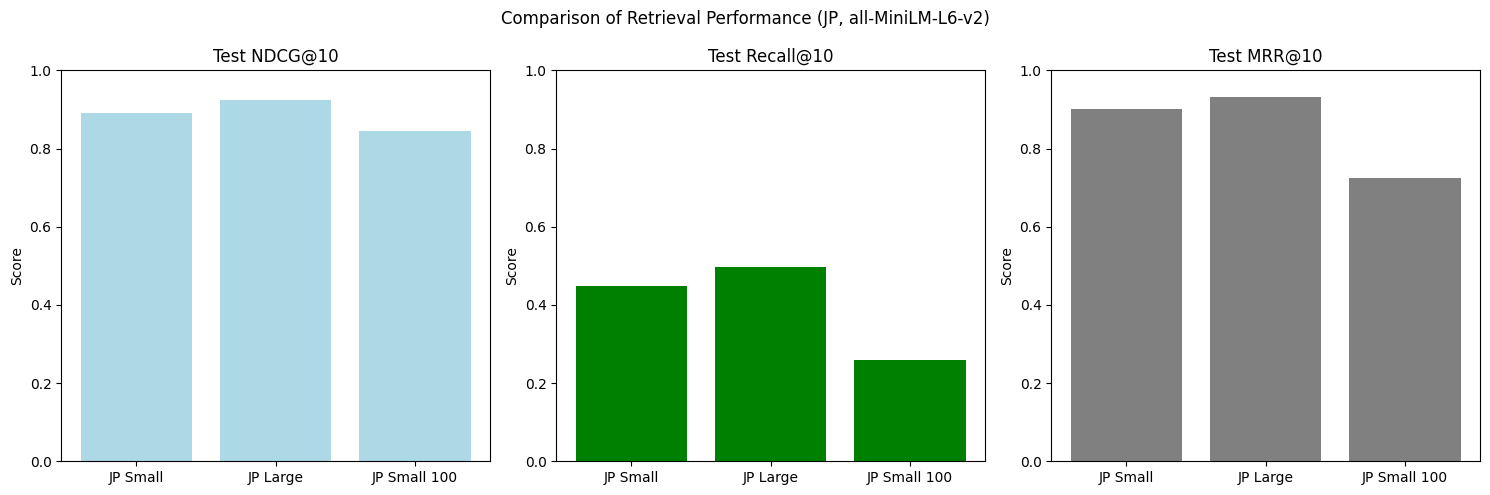

In [24]:
# Plot settings
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ["Test NDCG@10", "Test Recall@10", "Test MRR@10"]
colors = ["lightblue", "green", "grey"]

for i, metric in enumerate(metrics):
    axes[i].bar(jp_result_df["Title"], jp_result_df[metric], color=colors[i])
    axes[i].set_title(metric)
    axes[i].set_ylabel("Score")
    axes[i].set_ylim(0, 1)

plt.suptitle("Comparison of Retrieval Performance (JP, all-MiniLM-L6-v2)")
plt.tight_layout()
plt.show()

## Limitation and Future Steps

### Limitations

While the evaluation of the **all-MiniLM-L6-v2** model showed strong semantic retrieval performance, several limitations remain:

---
#### 1. Multilingual Coverage

The model was primarily pre-trained on English data.  
Although it handled multilingual queries (Japanese, Spanish) reasonably well, its effectiveness across non-English queries was not separately analyzed. Performance gaps across languages may exist.

#### 2. Low Recall@10, High NDCG@10 and MRR@10

While the model achieved high NDCG@10 and MRR@10 scores, the Recall@10 values were comparatively lower.  
This suggests that although the model ranks the most relevant items highly, it does not retrieve all possible relevant products within the top-10 results.

One key reason for the lower Recall@10 is the thresholding applied during evaluation:  
- Only products with a relevance label of **≥3** (i.e., Substitute and Exact matches) were considered "relevant."
- Irrelevant and Substitutes (labels 1 and 2) were treated as irrelevant, even though they may be partially useful.

This stricter definition of relevance reduced the number of "positive" samples per query, making it harder to achieve high Recall@10.

Other contributing factors include:
- The inherent label imbalance in the Shopping Queries Dataset, where many products are irrelevant to a query.
- The absence of fine-tuning specifically for the ESCI relevance labels (Exact, Substitute, Complement, Irrelevant).
- The strict evaluation at only top-10, which can penalize retrieval models that find relevant results ranked just outside the top 10 (e.g., 11th or 12th).

In addition, the high NDCG@10 and MRR@10 scores might be partially occurred due to the small candidate pool per query.
On average, each query had only about 23 products associated with it. Retrieving the top-10 from a pool of 20-25 is easier compared to a real-world retrieval scenario with thousands or millions of candidates.

This task primarily used a small candidate pool because the time required for embedding large numbers of product texts made full-scale evaluation computationally expensive with available resources.
Only one extended experiment was conducted using a larger candidate pool of **100 products per query**, and this resulted in a notable drop in all three metrics (NDCG, Recall, MRR), reinforcing the observation that small candidate pools can overestimate model effectiveness.

#### 3. Computational Cost

Although **all-MiniLM-L6-v2** is lightweight compared to larger transformer models, full dataset evaluation — especially for multilingual settings — still required significant computational time and resources.

Initially, running on CPU for the small English (us) test dataset took more than one hour, which is inefficient for practical experiments.  
To achieve reasonable inference speed, the evaluation process required access to a GPU.  

#### 4. Dataset Quality and Language Consistency

Although the dataset is labeled with a specific locale, such as **"us"** for English, it was observed that some entries still contain queries written in different languages.  
This inconsistency introduces noise into model evaluation, as language mismatches can confuse semantic retrieval models that expect consistent language patterns.

In particular, the presence of non-English queries or product descriptions within the English ("us") subset may slightly degrade retrieval performance and affect the reliability of evaluation metrics. 


In [15]:
# Limitation number 4: The dataset is not cleaned properly in terms of language filtering
loaded_data.df[loaded_data.df['query']=='香奈儿'].head(5)

,query,title,description,relevance,split,product_locale,combined_text
2614578,香奈儿,crystal ball photography crystal ball inspir...,,4,test,us,crystal ball photography crystal ball inspir...
2614579,香奈儿,chanel la mousse anti pollution cleansing crea...,chanel la mousse anti pollution cleansing crea...,4,test,us,chanel la mousse anti pollution cleansing crea...
2614580,香奈儿,lip smacker lippy pal lip balm unicorn magic ...,,1,test,us,lip smacker lippy pal lip balm unicorn magic ...
2614581,香奈儿,power full plump lip balm big o 0 17 oz,,1,test,us,power full plump lip balm big o 0 17 oz
2614582,香奈儿,winky lux flower balm color changing flower j...,natural clear lip gloss pack waterproof nude ...,4,test,us,winky lux flower balm color changing flower j...


### Future Steps

The following future steps are proposed to further improve model performance, evaluation reliability, and system efficiency:

---

#### 1. Evaluate Each Query Against the Full Dataset

- Currently, the main evaluation was performed on a small subset of products (approximately 23–25 candidates per query) and only one experiment with JP locale with 100 products per query. This is because of the high computational cost of embedding a large number of products.
- To better simulate a real-world retrieval scenario, where users typically search across thousands or millions of items, future work should evaluate each query against the entire product dataset.

#### 2. Fine-Tune the Model on ESCI Data

- Fine-tune the **all-MiniLM-L6-v2** model on the ESCI to adapt it specifically to the task of semantic product retrieval.
- Fine-tuning can help the model better understand the fine-grained distinctions between Exact, Substitute, Complement, and Irrelevant labels.
- Expected improvements include higher Recall@10, better NDCG@10 scores, and more accurate semantic matching for domain-specific queries.

#### 3. Optimize Computational Efficiency

- Continue utilizing GPUs for faster inference and evaluation.
- Explore efficient retrieval libraries (e.g., **FAISS**) to further reduce computational time and memory usage.

#### 4. Use More Models for Comparison

- Benchmark additional pre-trained sentence embedding models such as **all-mpnet-base-v2**, **multi-qa-mpnet-base-dot-v1**, **paraphrase-multilingual-MiniLM-L12-v2**, and **mpnet-base**.
- Compare performance across different architectures to identify models that might offer better recall, multilingual handling, or efficiency for this specific retrieval task.
- Analyze trade-offs between model size, computational cost, and retrieval accuracy to inform model selection for future production systems.

### Reproduce the evaluation result

In [26]:
import os
print("Current Working Directory:", os.getcwd())

# Change the working directory to src to run the scripts in the src folder
os.chdir('src/')

# Check the current working directory
print("Changed to Working Directory:", os.getcwd())

Current Working Directory: c:\Users\Wei\Assignment\Semantic-Search-Evaluation
Changed to Working Directory: c:\Users\Wei\Assignment\Semantic-Search-Evaluation\src


In [27]:
import torch
from src.evaluation_pipeline import run_evaluation
# Check if GPU is available and print the name of the GPU
print("Is GPU available?", torch.cuda.is_available())

Is GPU available? True


In [ ]:
# Run the evaluation pipeline for the model with US Small dataset 
results = run_evaluation(
        language="us",
        model_name="all-MiniLM-L6-v2",
        small_version=True,
        split_column="split",
        batch_size=128,
        save_results=False,
        example_path="../dataset/shopping_queries_dataset_examples.parquet",
        product_path="../dataset/shopping_queries_dataset_products.parquet",
    )

Current Working Directory: c:\Users\Wei\Assignment\Semantic-Search-Evaluation\src
Running on small version of the dataset
Initializing data preprocessor for language: us
Filtered dataset to 601354 rows with locale 'us'
                           query  \
16   awnmower tires without rims   
17   awnmower tires without rims   
18   awnmower tires without rims   
19   awnmower tires without rims   
20   awnmower tires without rims   

                                                title  \
16  rampro 10  all purpose utility air tires wheel...   
17  maxauto 2 pack 13x5 00 6 2ply turf mower tract...   
18  neiko 20601a 14 5 inch steel tire spoon lever ...   
19  2pk 13x5 00 6 13x5 00x6 13x5x6 13x5 6 2ply tur...   
20   set of 2  15x6 00 6 husqvarna poulan tire whe...   

                                          description  relevance  split  \
16  about the ram pro all purpose utility 10  air ...          1  train   
17  maxauto 2 pack 13x5 00 6 2ply turf mower tract...          4  train

Evaluating queries: 100%|██████████| 169/169 [11:57<00:00,  4.25s/it]



Evaluation Results:
--------------------------------------------------
Model: all-MiniLM-L6-v2
Dataset: ESCI US Small
Number of test queries: 20887
--------------------------------------------------
NDCG@10: 0.9060
Recall@10: 0.6077
MRR@10: 0.9242
Evaluating model on us test set...
                           query  \
32   qscreen fence without holes   
33   qscreen fence without holes   
34   qscreen fence without holes   
35   qscreen fence without holes   
36   qscreen fence without holes   

                                                title  \
32  fotmishu 6pcs greenhouse hoops rust free grow ...   
33  zippity outdoor products zp19028 unassembled m...   
34  zippity outdoor products zp19026 lightweight p...   
35  colourtree 4  x 50  green fence privacy screen...   
36  colourtree 6  x 50  black fence privacy screen...   

                                          description  relevance split  \
32  description material plastic coated steel pipe...          1  test   
33      

Evaluating queries: 100%|██████████| 73/73 [05:22<00:00,  4.42s/it]


Evaluation Results:
--------------------------------------------------
Model: all-MiniLM-L6-v2
Dataset: ESCI US Small
Number of test queries: 8955
--------------------------------------------------
NDCG@10: 0.9072
Recall@10: 0.6034
MRR@10: 0.9244

Total evaluation time: 1075.59 seconds




In [28]:
# Run the evaluation pipeline for the model with US Small dataset with extra products (100 products)
results = run_evaluation(
        language="jp",
        model_name="all-MiniLM-L6-v2",
        small_version=True,
        split_column="split",
        batch_size=2048,
        save_results=False,
        example_path="../dataset/shopping_queries_dataset_examples.parquet",
        product_path="../dataset/shopping_queries_dataset_products.parquet",
        product_size=100,
    )

Running on small version of the dataset
Initializing data preprocessor for language: jp
Filtered dataset to 297883 rows with locale 'jp'
           query                                              title  \
3502  &ハニー シャンプー          honeyplus ハニープラス スムース&リペアシャンプー 900ml 詰め替え   
3503  &ハニー シャンプー                     ハニープラス エアリートリートメント 500ml ２個セット   
3504  &ハニー シャンプー  アンドハニー ディープモイスト シャンプー トリートメント 詰め替え セット『超しっとり オ...   
3505  &ハニー シャンプー  dove(ダヴ) ダヴ ボタニカルセレクション ナチュラルシャイン シャンプー つめかえ用 ...   
3506  &ハニー シャンプー                  &honey jam&butter シャンプートリートメントセット   

                                            description  relevance  split  \
3502  🐝もこもこの弾力泡で傷んだ髪を優しく洗う、シリコーンフリーのアミノ酸系シャンプー。 🐝全成分...          3  train   
3503  ふんわりまとまる!髪と地肌にやさしい生ハチミツを使った柔らかい髪用トリートメント!サロン品質...          4  train   
3504  【商品説明】 特徴（特長） ●90％以上配合された保湿&保護成分が、髪に潤いを閉じ込めます。...          3  train   
3505                                                             4  train   
3506                      甘酸っぱく香る秋の限定品 「jam&butter」

Evaluating queries: 100%|██████████| 4/4 [06:59<00:00, 104.85s/it]



Evaluation Results:
--------------------------------------------------
Model: all-MiniLM-L6-v2
Dataset: ESCI JP Small
Number of test queries: 7283
--------------------------------------------------
NDCG@10: 0.8410
Recall@10: 0.2524
MRR@10: 0.7141
Evaluating model on jp test set...
         query                                              title  \
12756  0.4 ノズル  エアブラシ ダブルアクションエアーブラシ セットusb充電式エアブラシ 重力式 2種類ノズル...   
12757  0.4 ノズル  ganzton 19b エアブラシ セット 0.4mmノズル ミニコンプレッサー クリーナー...   
12758  0.4 ノズル  creality ホットエンド ブロックシリコーン 保護カバー 高温耐性 3個 + 0.4m...   
12759  0.4 ノズル  tronxy 3dアップグレードパーツ組み立て済みmk10エクストルーダーホットエンドキット...   
12760  0.4 ノズル  fularr® 3m ptfeテフロンチューブ、6個 pc4-m6フィッティング、6個 pc...   

                                             description  relevance split  \
12756  初心者でも簡単: 電源を入れて、レバーを下に押したまま手前に引くだけで、塗料がシューッと出ま...          3  test   
12757  製品仕様： サイズ：120 * 70 * 90mm 色：白、赤 重量：0.95kg 素材：銅...          4  test   
12758  仕様： 材質：耐熱性、非粘着性シリコーン  サイズ：23 x 23 x 13 mm / 0....          3  te

Evaluating queries: 100%|██████████| 2/2 [02:40<00:00, 80.46s/it] 


Evaluation Results:
--------------------------------------------------
Model: all-MiniLM-L6-v2
Dataset: ESCI JP Small
Number of test queries: 3123
--------------------------------------------------
NDCG@10: 0.8430
Recall@10: 0.2594
MRR@10: 0.7229

Total evaluation time: 598.47 seconds


